In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

# 2. EDA & 전처리

## Missing Value

In [5]:
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

### outlier

### education

In [6]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [7]:
df = pd.concat([train, test])
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [28]:
var = 800000
train.loc[train['fnlwgt'] > var, 'fnlwgt'] = var + np.random.randint(0,1000)
test.loc[test['fnlwgt'] > var, 'fnlwgt'] = var + np.random.randint(0,1000)

# 3. 모델 학습

In [29]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          #, ignore_features = ['capital_gain','capital_loss']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 14)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 3.87 s


In [30]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

IntProgress(value=0, description='Processing: ', max=98)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:41:37
Status,. . . . . . . . . . . . . . . . . .,Fitting Fold 10 of 10
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier
ETC,. . . . . . . . . . . . . . . . . .,11.4 Seconds Remaining


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8645,0.9209,0.6439,0.7599,0.6969,0.6104,0.6140,0.2931
1,Extreme Gradient Boosting,0.8626,0.9201,0.6439,0.7529,0.6939,0.6060,0.6093,2.0858
2,Gradient Boosting Classifier,0.8632,0.9177,0.6083,0.7783,0.6826,0.5971,0.6046,1.9847
3,Ada Boost Classifier,0.8574,0.9115,0.6180,0.7492,0.6771,0.5867,0.5913,0.7299
4,Linear Discriminant Analysis,0.8462,0.9000,0.5934,0.7221,0.6510,0.5536,0.5583,0.1744
5,Extra Trees Classifier,0.8348,0.8844,0.5973,0.6820,0.6363,0.5301,0.5324,0.5348
6,Random Forest Classifier,0.8436,0.8776,0.5584,0.7332,0.6335,0.5364,0.5448,0.1247


KeyboardInterrupt: 

In [ ]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

In [ ]:
pred_holdout = predict_model(blended)

In [14]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 9s


In [15]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [16]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [17]:
submission.to_csv('output/20201017-5.csv')

In [18]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8716,0.9237,0.6375,0.7912,0.7061,0.6251,0.6311
1,0.8630,0.9183,0.6667,0.7410,0.7019,0.6132,0.6147
2,0.8630,0.9175,0.6570,0.7463,0.6988,0.6106,0.6126
3,0.8597,0.9152,0.6364,0.7452,0.6865,0.5969,0.6000
4,0.8417,0.9071,0.6181,0.6945,0.6541,0.5519,0.5535
5,0.8723,0.9298,0.6634,0.7765,0.7155,0.6338,0.6371
6,0.8785,0.9358,0.6570,0.8056,0.7237,0.6469,0.6524
7,0.8652,0.9249,0.6408,0.7645,0.6972,0.6114,0.6153
8,0.8613,0.9236,0.6214,0.7619,0.6845,0.5968,0.6019
9,0.8730,0.9215,0.6861,0.7653,0.7235,0.6415,0.6431


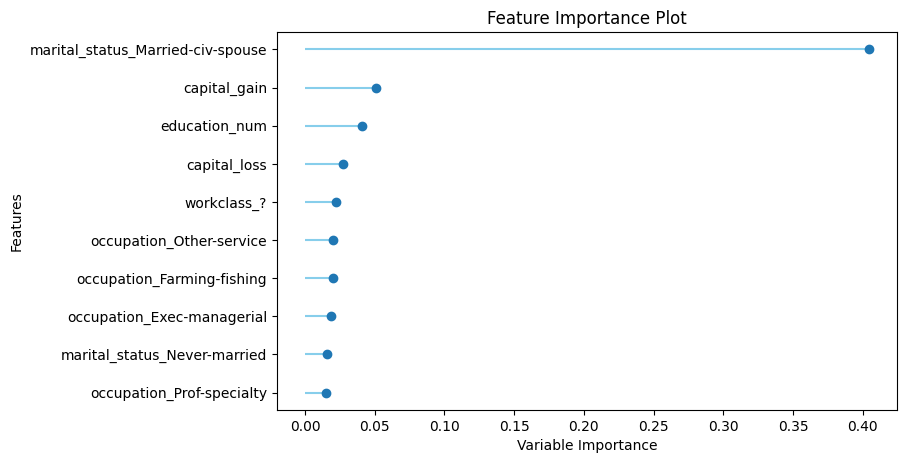

In [19]:
plot_model(estimator = xgboost, plot = 'feature')

In [20]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8630,0.9202,0.6246,0.7659,0.6881,0.6014,0.6065
1,0.8614,0.9191,0.6602,0.7391,0.6974,0.6079,0.6095
2,0.8614,0.9161,0.6602,0.7391,0.6974,0.6079,0.6095
3,0.8574,0.9120,0.6169,0.7480,0.6762,0.5858,0.5903
4,0.8503,0.9091,0.6052,0.7305,0.6619,0.5669,0.5710
5,0.8699,0.9311,0.6667,0.7658,0.7128,0.6292,0.6318
6,0.8824,0.9357,0.6634,0.8167,0.7321,0.6579,0.6637
7,0.8605,0.9196,0.6278,0.7549,0.6855,0.5969,0.6010
8,0.8715,0.9240,0.6440,0.7866,0.7082,0.6268,0.6320
9,0.8683,0.9187,0.6634,0.7621,0.7093,0.6248,0.6273


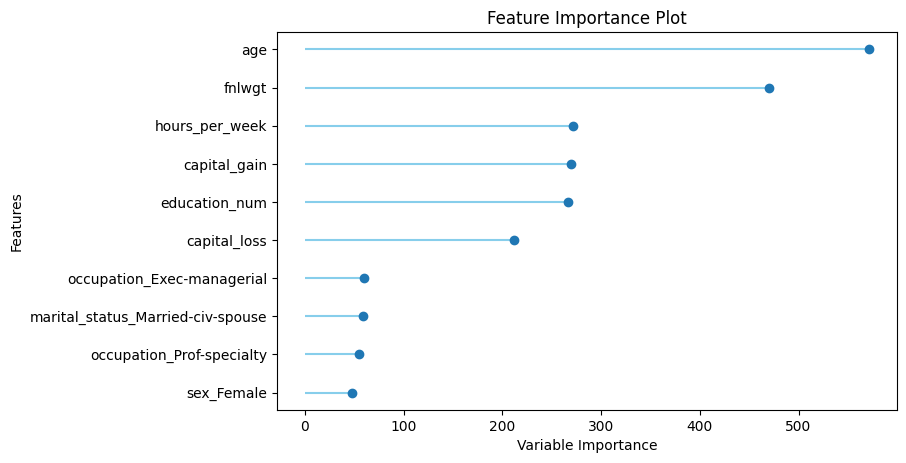

In [21]:
plot_model(estimator = lightgbm, plot = 'feature')